In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Download the street network for Skellefteå, Sweden
place_name = "Skellefteå, Sweden"
G = ox.graph_from_place(place_name, network_type='drive')

# Function to assign speed or default speed
def assign_speed(data):
    # If maxspeed is available, use it
    if 'maxspeed' in data:
        if isinstance(data['maxspeed'], list):
            speed = float(data['maxspeed'][0])  # Use the first speed limit
        else:
            speed = float(data['maxspeed'].split()[0])  # Convert string to float
    else:
        # Assign default speed based on road type if maxspeed is missing
        highway_type = data.get('highway', '')
        if highway_type in ['motorway', 'motorway_link']:
            speed = 120  # 120 km/h
        elif highway_type in ['trunk', 'trunk_link']:
            speed = 100  # 100 km/h
        elif highway_type in ['primary', 'primary_link']:
            speed = 80   # 80 km/h
        elif highway_type in ['secondary', 'secondary_link']:
            speed = 60   # 60 km/h
        elif highway_type in ['tertiary', 'tertiary_link', 'unclassified', 'residential']:
            speed = 40   # 40 km/h
        else:
            speed = 30   # 30 km/h for smaller roads
    return speed

# Add speed limit to each edge
for u, v, key, data in G.edges(keys=True, data=True):
    data['speed'] = assign_speed(data)  # Assign speed in km/h

# Extract speeds to use for color mapping
speeds = [data['speed'] for u, v, key, data in G.edges(keys=True, data=True)]

# Set up a color map for visualizing speeds (slower roads are blue, faster are red)
cmap = plt.cm.get_cmap('coolwarm')
norm = mcolors.Normalize(vmin=min(speeds), vmax=max(speeds))

# Plot the graph, coloring edges by speed
fig, ax = ox.plot_graph(
    G, 
    edge_color=[cmap(norm(data['speed'])) for u, v, key, data in G.edges(keys=True, data=True)],
    edge_linewidth=2, 
    node_size=0,
    bgcolor='white'
)

# Add a colorbar to represent the speed limits
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(speeds)
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Speed limit (km/h)')

plt.show()


ValueError: could not convert string to float: 'walk'

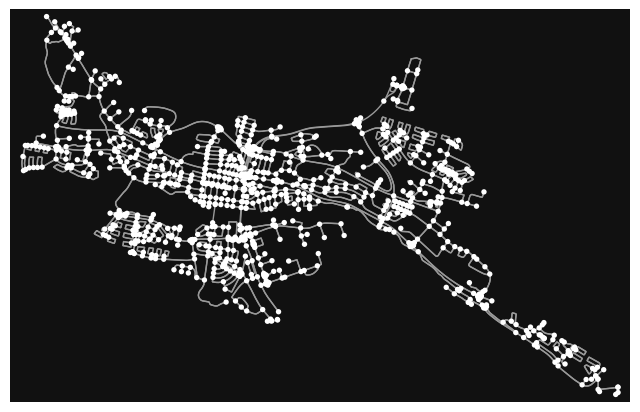

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
import osmnx as ox
import networkx as nx

# Create a street network graph for Skellefteå, Sweden
place_name = "Skellefteå, Sweden"
G = ox.graph_from_place(place_name, network_type='drive')

# Plot the graph (optional)
ox.plot_graph(G)


In [6]:
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# Function to generate the distance matrix
def generate_distance_matrix(G, customer_locations, depot_location):
    nearest_nodes = [ox.distance.nearest_nodes(G, lon, lat) for lat, lon in customer_locations]
    depot_node = ox.distance.nearest_nodes(G, depot_location[1], depot_location[0])
    nodes = [depot_node] + nearest_nodes

    distance_matrix = []
    for node_u in nodes:
        row = []
        for node_v in nodes:
            length = nx.shortest_path_length(G, source=node_u, target=node_v, weight='length')
            row.append(length)
        distance_matrix.append(row)

    return distance_matrix, nodes

# Create OSMnx graph for Skellefteå, Sweden
place_name = "Skellefteå, Sweden"
G = ox.graph_from_place(place_name, network_type='drive')

# Define customer and depot locations
customer_locations = [
    (64.7502, 20.9508),  # Customer 1
    (64.7533, 20.9570),  # Customer 2
    (64.7560, 20.9425),  # Customer 3
    (64.7515, 20.9601),  # Customer 4
    (64.7498, 20.9487),  # Customer 5
    (64.7541, 20.9550),  # Customer 6
    (64.7552, 20.9460),  # Customer 7
    (64.7527, 20.9542),  # Customer 8
]
depot_location = (64.7511, 20.9525)  # Depot location

# Generate distance matrix using OSMnx graph
distance_matrix, nodes = generate_distance_matrix(G, customer_locations, depot_location)

# Define the number of vehicles and the depot index (first node is the depot)
num_vehicles = 3
depot_index = 0  # First node is the depot

# Define customer service requirements as a dictionary indexed from 1 (each customer can have multiple requirements)
customer_requirements = {
    1: ["medication", "pharmacy"],     # Customer 1
    2: ["toilet", "grocery"],          # Customer 2
    3: ["food"],                       # Customer 3
    4: ["pharmacy", "food"],           # Customer 4
    5: ["grocery", "stationery"],      # Customer 5
    6: ["hardware"],                   # Customer 6
    7: ["electronics", "hardware"],    # Customer 7
    8: ["stationery", "toilet"],       # Customer 8
}

# Define vehicle capabilities as a dictionary indexed from 1 (each vehicle can fulfill certain services)
vehicle_capabilities = {
    1: ["medication", "pharmacy"],              # Vehicle 1 can provide medication and pharmacy
    2: ["food", "grocery", "toilet"],           # Vehicle 2 can provide food, grocery, and toilet services
    3: ["hardware", "electronics", "stationery"] # Vehicle 3 can provide hardware, electronics, and stationery services
}

# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(distance_matrix), num_vehicles, depot_index)

# Create the Routing Model
routing = pywrapcp.RoutingModel(manager)

# Create the distance callback
def distance_callback(from_index, to_index):
    """Returns the distance between two nodes."""
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(distance_matrix[from_node][to_node])  # Ensure integer distances

# Register the distance callback
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Set the cost of travel (objective is to minimize the total distance)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Define a function to enforce vehicle-specific service capabilities
def vehicle_service_compatibility(vehicle_id, customer_id):
    """Returns True if the vehicle can serve the customer based on service requirements."""
    # The vehicle can serve the customer only if it can fulfill ALL the customer's requirements
    customer_services = customer_requirements[customer_id]
    vehicle_services = vehicle_capabilities[vehicle_id]
    return all(service in vehicle_services for service in customer_services)

# Apply constraints to enforce vehicle service compatibility
for node_index in range(1, len(customer_locations) + 1):
    allowed_vehicles = []
    customer_id = node_index  # Nodes are 1-based indexing
    for vehicle_id in range(1, num_vehicles + 1):
        if vehicle_service_compatibility(vehicle_id, customer_id):
            allowed_vehicles.append(vehicle_id - 1)  # Adjust to 0-based indexing
    if not allowed_vehicles:
        print(f"No vehicles can serve customer {customer_id}")
        # Optionally, you can add a disjunction with a very high penalty to avoid unassigned customers
        routing.AddDisjunction([manager.NodeToIndex(node_index)], 1000000)
        #Lägga till penalty baserat på kravet som inte tillgodoses, ex medicin har högre penalty än toalett
    else:
        # Set allowed vehicles for this node
        routing.VehicleVar(manager.NodeToIndex(node_index)).SetValues(allowed_vehicles)

# Optional: Add a dimension to limit the number of stops for each vehicle
max_stops = 10  # Limit the number of customers per vehicle
stops_per_vehicle = [max_stops] * num_vehicles
demand_evaluator_index = routing.RegisterUnaryTransitCallback(lambda index: 1)

routing.AddDimensionWithVehicleCapacity(
    demand_evaluator_index,
    0,  # No slack
    stops_per_vehicle,  # Vehicle capacities
    True,  # Start cumul to zero
    "Stops"
)

# Solve the problem
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 10  # Adjust time limit as needed

solution = routing.SolveWithParameters(search_parameters)

# Output the solution
if solution:
    total_distance = 0
    for vehicle_id in range(num_vehicles):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id + 1}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            plan_output += f" {node_index} ->"
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += f" {manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance} meters\n"
        print(plan_output)
        total_distance += route_distance
    print(f"Total distance of all routes: {total_distance} meters")
else:
    print("No solution found!")


1055
No vehicles can serve customer 4
No vehicles can serve customer 5
No vehicles can serve customer 8
Route for vehicle 1:
 0 -> 5 -> 1 -> 0
Distance of the route: 846 meters

Route for vehicle 2:
 0 -> 3 -> 2 -> 0
Distance of the route: 2226 meters

Route for vehicle 3:
 0 -> 8 -> 7 -> 6 -> 4 -> 0
Distance of the route: 2429 meters

Total distance of all routes: 5501 meters
